# Jonathan Halverson
# Keeping it Fresh: Predict Restaurant Inspections
## Part 1: Health inspection violation data

This notebook examines the health inspection violation data. We propose two simple models for benchmarking purposes. We do not work with the Yelp data in this notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [2]:
df = pd.read_csv('data/training_labels.txt', parse_dates=['date'])
df.head()

,id,date,restaurant_id,*,**,***
0,589,2010-02-02,KAoKWjog,3,0,1
1,28589,2009-12-10,p038M4om,2,0,0
2,31170,2008-07-16,B1oXymOV,4,0,0
3,2600,2015-01-30,m0oWJl3G,1,0,3
4,1016,2012-03-19,rJoQwlEV,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27088 entries, 0 to 27087
Data columns (total 6 columns):
id               27088 non-null int64
date             27088 non-null datetime64[ns]
restaurant_id    27088 non-null object
*                27088 non-null int64
**               27088 non-null int64
***              27088 non-null int64
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 1.2+ MB


### Remove duplicate inspection records

There are a few thousand records where for a given restaurant the number of violations are the same with the inspection date differing by only a few days. Next we remove all such records when the spacing is less than 60 days:

In [4]:
from helper_methods import drop_duplicate_inspections
df = df.sort_values(['restaurant_id', 'date'])
df = drop_duplicate_inspections(df, threshold=60)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20288 entries, 1801 to 5854
Data columns (total 6 columns):
id               20288 non-null int64
date             20288 non-null datetime64[ns]
restaurant_id    20288 non-null object
*                20288 non-null int64
**               20288 non-null int64
***              20288 non-null int64
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 1.1+ MB


In [6]:
df.describe().applymap(lambda x: round(x, 4))

,id,*,**,***
count,20288.0000,20288.000,20288.0000,20288.0000
mean,16997.0692,3.719,0.3189,0.8357
std,9796.3724,4.223,0.6179,1.4667
min,1.0000,0.000,0.0000,0.0000
25%,8531.5000,0.000,0.0000,0.0000
50%,17007.5000,3.000,0.0000,0.0000
75%,25503.0000,6.000,1.0000,1.0000
max,33859.0000,49.000,7.0000,17.0000


### Zero model

Our first model is to simply predict the median number of violations across all inspections. This would be 3, 0, 0 for 1-star, 2-star, 3-star as seen in the 6th row in the table above. While this completely ignores the Yelp data it gives us a well-understood benchmark which we will surely beat.

In [7]:
sb = pd.read_csv('submit/SubmissionFormat.csv')
sb['*'] = 3
sb.to_csv('zero_model.csv', index=False, header=True)
sb.head()

,id,date,restaurant_id,*,**,***
0,14916,2014-12-17,nkOvZOBW,3,0,0
1,29767,2013-12-30,WwOaAnOB,3,0,0
2,29338,2011-04-08,we39kvOk,3,0,0
3,7219,2013-12-30,dj3d5Xo9,3,0,0
4,20979,2008-03-31,XJ3rBW3R,3,0,0


### Convert date to NumPy data type

In [8]:
# the next line is not needed because we chose to convert to datetime in read_csv() above
#df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

### Check for unique values

Let's look at the number of unique values per column:

In [9]:
for column in df.columns:
    print df.shape[0], df[column].unique().size, column

20288 20288 id
20288 2058 date
20288 1851 restaurant_id
20288 44 *
20288 8 **
20288 18 ***


We see that the id's are unique while the restaurant_id's suggest multiple inspections.

### Which days of the week are the inspections carried out on and how many per year?

(-0.5, 6.5)

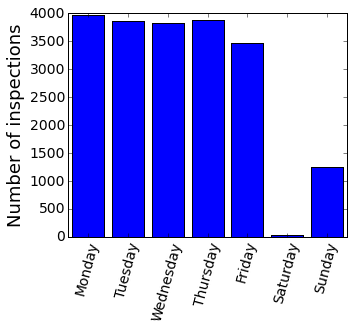

In [10]:
counts, _ = np.histogram(df['date'].apply(lambda x: x.dayofweek), bins=7, range=(0, 7))
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plt.bar(range(7), counts, align='center')
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.xticks(range(7), labels, rotation=75)
plt.ylabel('Number of inspections')
plt.xlim(-0.5, 6.5)

(-0.5, 9.5)

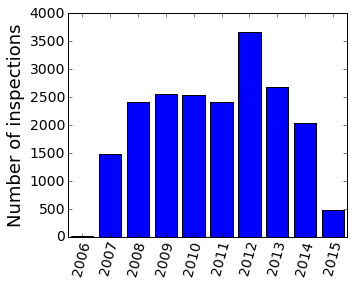

In [11]:
counts, _ = np.histogram(df['date'].apply(lambda x: x.year), bins=10, range=(2006, 2016))
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plt.bar(range(10), counts, align='center')
labels = range(2006, 2017)
plt.xticks(range(10), labels, rotation=75)
plt.ylabel('Number of inspections')
plt.xlim(-0.5, 9.5)

Data for 2015 is not complete.

### Plot the violation data

Visualize the violations by date and level:

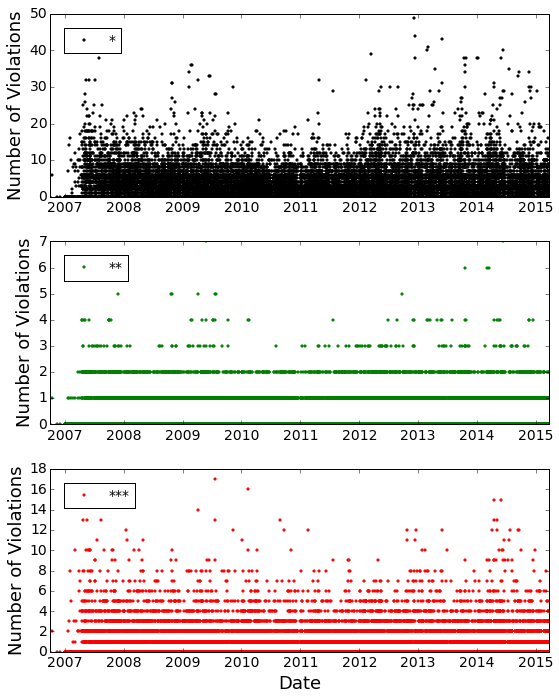

In [12]:
clr = ['k', 'g', 'r']
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8, 10))
for i, stars in enumerate(['*', '**', '***']):
    ax[i].plot(df.date, df[stars], '.', color=clr[i], label=stars, ms=5)
    if (i == 2): ax[i].set_xlabel('Date')
    ax[i].set_ylabel('Number of Violations')
    ax[i].legend(loc='upper left')
plt.tight_layout()

The number of violations of each type is approximately uniform over time. There are many more one-star violations than the other two.

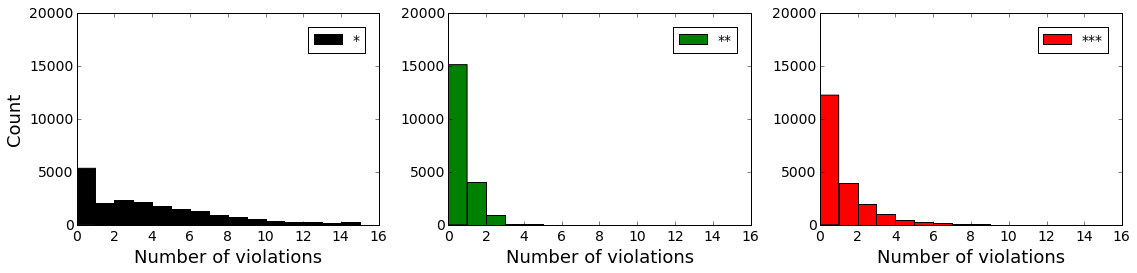

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
for i, stars in enumerate(['*', '**', '***']):
    ax[i].hist(df[stars].values, label=stars, color=clr[i], bins=15, width=1, range=(0, 15))
    ax[i].set_xlabel('Number of violations')
    if (i == 0): ax[i].set_ylabel('Count')
    ax[i].legend(loc='upper right')
    ax[i].set_ylim(0, 20000)
plt.tight_layout()

### How many times were each of the 1851 restaurants inspected?

In [14]:
num_inspect = pd.crosstab(index=df["restaurant_id"], columns="count")
num_inspect.columns = ["Number of inspections"]
num_inspect.sort_values('Number of inspections', ascending=False, inplace=True)
num_inspect.head(10)

,Number of inspections
restaurant_id,
1JEbamOR,34
Y1EmLmOw,30
KAoKz83g,27
dj3dX539,27
Pk3w4wod,26
wmo7bb3q,26
qN3gJ2EA,26
JGoN9b3L,26
6K3l8K3z,26


In [15]:
most_rated = df.groupby('restaurant_id').size().sort_values(ascending=False)[:10]
most_rated

restaurant_id
1JEbamOR    34
Y1EmLmOw    30
KAoKz83g    27
dj3dX539    27
JGoN9b3L    26
wmo7bb3q    26
qN3gJ2EA    26
Pk3w4wod    26
ZBEnaqOY    26
JBEyG0o8    26
dtype: int64

In [16]:
df.restaurant_id.value_counts()[:10]

1JEbamOR    34
Y1EmLmOw    30
dj3dX539    27
KAoKz83g    27
Pk3w4wod    26
wmo7bb3q    26
ZBEnaqOY    26
JGoN9b3L    26
qN3gJ2EA    26
JBEyG0o8    26
Name: restaurant_id, dtype: int64

In [17]:
num_inspect.describe()

,Number of inspections
count,1851.000000
mean,10.960562
std,5.501062
min,1.000000
25%,7.000000
50%,11.000000
75%,15.000000
max,34.000000


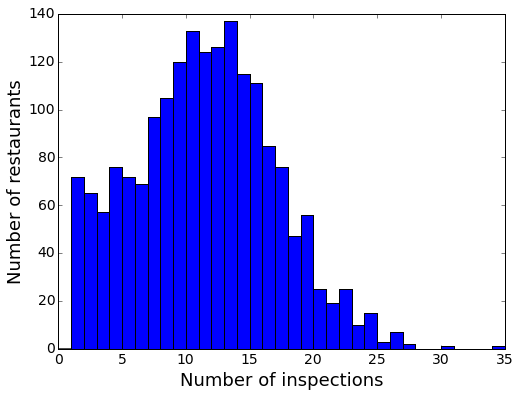

In [18]:
plt.hist(num_inspect['Number of inspections'], bins=35, range=(0, 35))
plt.xlabel('Number of inspections')
plt.ylabel('Number of restaurants')

Let's look at the violations of the restaurant with the most inspections:

In [19]:
most_inspections = df[df.restaurant_id == num_inspect.index[0]]
most_inspections.sort_values('date')

,id,date,restaurant_id,*,**,***
19747,14966,2007-02-12,1JEbamOR,10,1,5
22753,11966,2007-02-22,1JEbamOR,8,1,1
9808,10832,2007-08-14,1JEbamOR,11,2,2
25338,13814,2007-08-15,1JEbamOR,12,2,2
3851,28890,2007-12-10,1JEbamOR,6,1,2
11194,28482,2008-03-11,1JEbamOR,20,2,4
11888,2823,2008-03-18,1JEbamOR,12,2,0
15470,26600,2008-09-26,1JEbamOR,7,2,1
7813,787,2008-12-08,1JEbamOR,3,1,0
1842,12597,2009-03-10,1JEbamOR,5,0,1


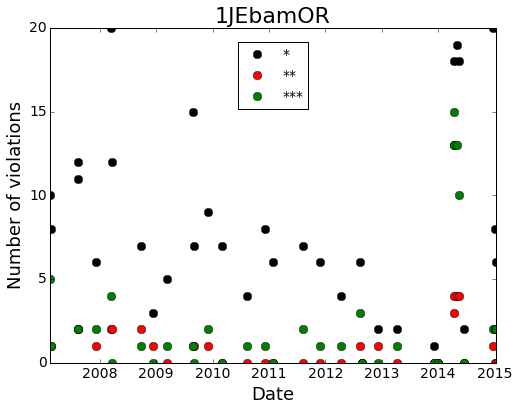

In [20]:
plt.plot(most_inspections.date, most_inspections['*'], 'ko', label='*')
plt.plot(most_inspections.date, most_inspections['**'], 'ro', label='**')
plt.plot(most_inspections.date, most_inspections['***'], 'go', label='***')
plt.xlabel('Date')
plt.ylabel('Number of violations')
plt.legend(loc='upper center')
plt.title(num_inspect.index[0])

### Average number of violations for each restaurant (sorted by most violations or worst restaurants)

The size column below gives the number of inspections for each restaurant.

In [21]:
df['weighted_violations'] = 1 * df['*'] + 3 * df['**'] + 5 * df['***']
avg_violations = df.groupby('restaurant_id').agg({'*': [np.size, np.mean, np.sum], '**': [np.mean, np.sum], '***': [np.mean, np.sum], 'weighted_violations': [np.mean, np.sum]})
avg_violations.sort_values([('weighted_violations', 'mean')], ascending=False).head(10)

weighted_violations         *                       ***      \
                             mean  sum size       mean  sum      mean sum   
restaurant_id                                                               
N6OkRvox                50.000000  100    2  19.000000   38  5.000000  10   
VpoGe9Er                38.000000   38    1   7.000000    7  5.000000   5   
ZBEnAqOY                32.666667   98    3   8.333333   25  3.666667  11   
N6OkxvEx                28.000000   84    3   7.666667   23  3.666667  11   
WwOapwoB                28.000000   28    1  18.000000   18  2.000000   2   
p038YGom                27.437500  439   16   8.437500  135  3.500000  56   
VpoGGAor                27.000000  324   12   8.250000   99  3.250000  39   
NbE1xaOJ                26.772727  589   22  11.227273  247  2.590909  57   
0ZEDeW3D                26.750000  107    4   7.750000   31  3.500000  14   
8x3zj93k                26.125000  209    8   7.625000   61  3.250000  26   

                     **      
                   mean sum  
restaurant_id                
N6OkRvox       2.000000   4  
VpoGe9Er       2.000000   2  
ZBEnAqOY       2.000000   6  
N6OkxvEx       0.666667   2  
WwOapwoB       0.000000   0  
p038YGom       0.500000   8  
VpoGGAor       0.833333  10  
NbE1xaOJ       0.863636  19  
0ZEDeW3D       0.500000   2  
8x3zj93k       0.750000   6

Do the number of violations depend on the size of the restaurant? If so would need to take this into account. See the Yelp check-in notebook for a plot of number of check-ins versus weighted violations. There is no correlation.

### Average violations model

In [22]:
sb = pd.read_csv('submit/SubmissionFormat.csv')
sb.head()

,id,date,restaurant_id,*,**,***
0,14916,2014-12-17,nkOvZOBW,0,0,0
1,29767,2013-12-30,WwOaAnOB,0,0,0
2,29338,2011-04-08,we39kvOk,0,0,0
3,7219,2013-12-30,dj3d5Xo9,0,0,0
4,20979,2008-03-31,XJ3rBW3R,0,0,0


In [23]:
sb_avg_violations = pd.merge(sb, avg_violations, left_on='restaurant_id', right_index=True, how='left').ix[:, [0, 1, 2, 9, 13, 11]]
sb_avg_violations.columns = ['id', 'date', 'restaurant_id', '*', '**', '***']
sb_avg_violations.head()

,id,date,restaurant_id,*,**,***
0,14916,2014-12-17,nkOvZOBW,4.230769,0.153846,0.615385
1,29767,2013-12-30,WwOaAnOB,4.076923,0.153846,1.000000
2,29338,2011-04-08,we39kvOk,3.111111,0.111111,1.000000
3,7219,2013-12-30,dj3d5Xo9,1.937500,0.250000,0.312500
4,20979,2008-03-31,XJ3rBW3R,4.428571,1.000000,1.142857


There are a few restaurants in the submission file which are not in the training data:

In [24]:
sb_avg_violations[sb_avg_violations['*'].isnull()]

,id,date,restaurant_id,*,**,***
27,21573,2014-06-27,KAoKJK3g,NaN,NaN,NaN
390,13795,2012-12-30,v5oJ5r3B,NaN,NaN,NaN
468,4154,2012-12-30,Pk3wAqOd,NaN,NaN,NaN
1000,24260,2012-12-30,ZBEndKoY,NaN,NaN,NaN
1160,20517,2012-12-30,8x3zvR3k,NaN,NaN,NaN
1186,13347,2012-12-30,7RO5MrOq,NaN,NaN,NaN
1291,30607,2014-09-26,NbE17moJ,NaN,NaN,NaN
1579,18020,2010-02-08,1JEbg73R,NaN,NaN,NaN
2125,23872,2012-12-30,JGoNX6EL,NaN,NaN,NaN
2506,8806,2012-12-30,njoZZBor,NaN,NaN,NaN


Use the zero model predictions for these cases:

In [25]:
sb_avg_violations['*'].fillna(3, inplace=True)
sb_avg_violations['**'].fillna(0, inplace=True)
sb_avg_violations['***'].fillna(0, inplace=True)
sb_avg_violations[['*', '**', '***']] = sb_avg_violations[['*', '**', '***']].astype(int)

In [26]:
sb_avg_violations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6772 entries, 0 to 6771
Data columns (total 6 columns):
id               6772 non-null int64
date             6772 non-null object
restaurant_id    6772 non-null object
*                6772 non-null int64
**               6772 non-null int64
***              6772 non-null int64
dtypes: int64(4), object(2)
memory usage: 317.5+ KB


In [27]:
sb_avg_violations.to_csv('avg_violations_model.csv', index=False, header=True)
sb_avg_violations.head()

,id,date,restaurant_id,*,**,***
0,14916,2014-12-17,nkOvZOBW,4,0,0
1,29767,2013-12-30,WwOaAnOB,4,0,1
2,29338,2011-04-08,we39kvOk,3,0,1
3,7219,2013-12-30,dj3d5Xo9,1,0,0
4,20979,2008-03-31,XJ3rBW3R,4,1,1


### How bad are the worst violators?

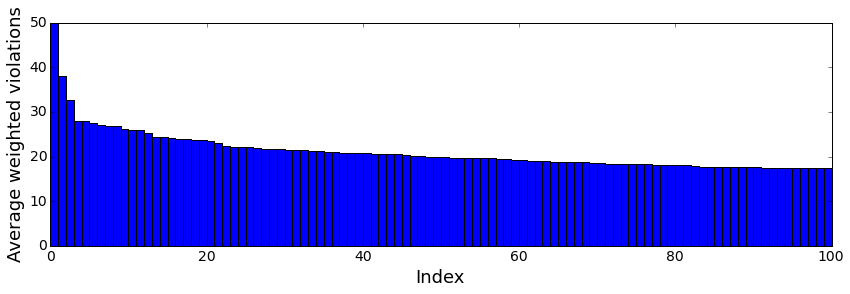

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
worst100 = avg_violations.sort_values([('weighted_violations', 'mean')], ascending=False).head(100)
plt.bar(range(100), worst100[('weighted_violations', 'mean')], width=1)
plt.xlabel('Index')
plt.ylabel('Average weighted violations')

Below are the restaurants with the least weighted_violations. Note that many have few inspections.

In [29]:
avg_violations.sort_values([('weighted_violations', 'mean')], ascending=False).tail()

weighted_violations        *           ***       **    
                             mean sum size mean sum mean sum mean sum
restaurant_id                                                        
N6OkdqEx                      0.0   0    1  0.0   0  0.0   0  0.0   0
NbE18JOJ                      0.0   0    2  0.0   0  0.0   0  0.0   0
8x3z5bEk                      0.0   0    2  0.0   0  0.0   0  0.0   0
NbE1PkOJ                      0.0   0    1  0.0   0  0.0   0  0.0   0
KAoKpKOg                      0.0   0    1  0.0   0  0.0   0  0.0   0

### Time period over which inspections have taken place by restaurant

The column inspect_window is the number of years between the first and last inspection:

In [30]:
dt = df.groupby('restaurant_id').agg({'date': [np.min, np.max]})
dt['inspect_window'] = (dt[('date', 'amax')] - dt[('date', 'amin')]) / np.timedelta64(1, 'Y')
dt.describe()

,inspect_window
,
count,1851.000000
mean,5.492126
std,2.048741
min,0.000000
25%,4.603791
50%,6.113746
75%,7.047373
max,8.421802


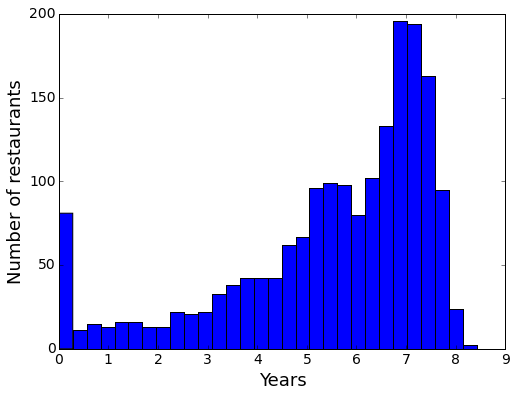

In [31]:
plt.hist(dt[('inspect_window')], bins=30)
plt.xlabel('Years')
plt.ylabel('Number of restaurants')

### How many times is a restaurant inspected in a year?

In [32]:
dates_inspections = pd.merge(dt, pd.DataFrame(df.groupby('restaurant_id').size()), left_index=True, right_index=True, how='inner')
dates_inspections.columns = ['min_date', 'max_date', 'inspect_window', 'number_of_inspections']
dates_inspections.describe()

,inspect_window,number_of_inspections
count,1851.000000,1851.000000
mean,5.492126,10.960562
std,2.048741,5.501062
min,0.000000,1.000000
25%,4.603791,7.000000
50%,6.113746,11.000000
75%,7.047373,15.000000
max,8.421802,34.000000


Next we filter out cases with only 1 inspection (to remove inf) and compute a rate column:

In [33]:
dates_inspections = dates_inspections[dates_inspections['number_of_inspections'] > 1]
dates_inspections['inspection_rate'] = dates_inspections['number_of_inspections'] / dates_inspections['inspect_window']
dates_inspections.describe()

,inspect_window,number_of_inspections,inspection_rate
count,1779.000000,1779.000000,1779.000000
mean,5.714404,11.363687,2.130592
std,1.759662,5.225602,2.029412
min,0.030117,2.000000,0.343758
25%,4.847464,8.000000,1.548595
50%,6.226001,11.000000,1.984184
75%,7.066538,15.000000,2.450325
max,8.421802,34.000000,66.407727


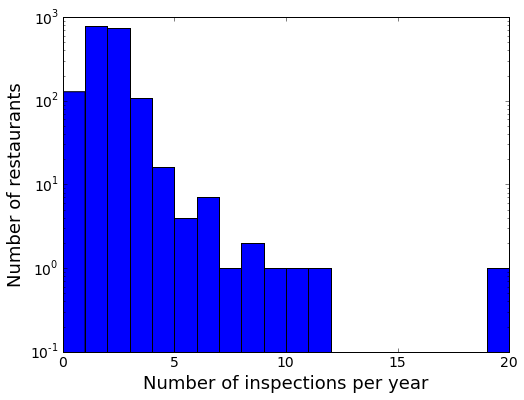

In [34]:
plt.hist(dates_inspections['inspection_rate'], bins=20, range=(0, 20), log=True)
plt.ylim(0.1, 1000)
plt.ylabel('Number of restaurants')
plt.xlabel('Number of inspections per year')
plt.ylabel('Number of restaurants')

### Last date of inspection

In [35]:
dt.head()

date            inspect_window
                    amin       amax               
restaurant_id                                     
0ZED0WED      2007-09-21 2014-10-08       7.047373
0ZED1B3D      2009-10-30 2014-09-03       4.843357
0ZED4ED9      2007-05-10 2012-12-30       5.642826
0ZED4pED      2007-08-14 2010-12-20       3.351198
0ZED543D      2007-12-03 2012-12-30       5.076080

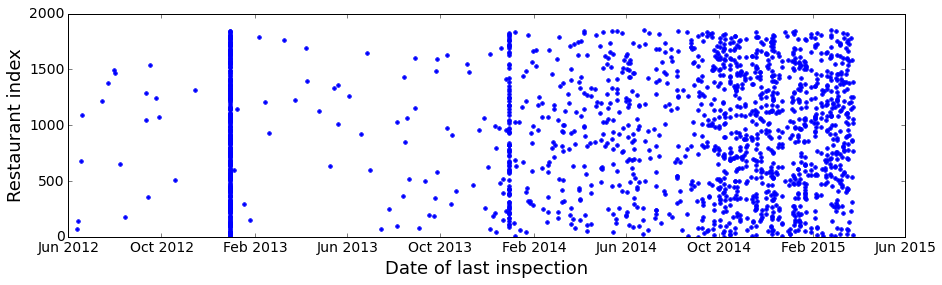

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
plt.plot(dt[('date', 'amax')], range(dt.index.size), '.')
plt.xlim(pd.to_datetime('2012-06-01'), pd.to_datetime('2015-06-01'))
plt.xlabel('Date of last inspection')
plt.ylabel('Restaurant index')